<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/unet_own_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0" #use the old version

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 63.2MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [2]:
from fastai import *
from fastai.vision import *

In [3]:
import json
from copy import deepcopy

In [4]:
!pip install ipdb
from ipdb import set_trace as st

  Created wheel for ipdb: filename=ipdb-0.13.4-cp36-none-any.whl size=10973 sha256=d5934c64de55e88be467e3daef9a1a299f82e05b035c658706cd466f4c2df021
  Stored in directory: /root/.cache/pip/wheels/56/51/e4/c91c61e3481a1a967beb18c4ea7a2b138a63cce94170b2e206
Successfully built ipdb


In [5]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

[PosixPath('/root/.fastai/data/camvid_tiny/labels'),
 PosixPath('/root/.fastai/data/camvid_tiny/codes.txt'),
 PosixPath('/root/.fastai/data/camvid_tiny/images')]

In [6]:
!cat /root/.fastai/data/camvid_tiny/codes.txt

Animal
Archway
Bicyclist
Bridge
Building
Car
CartLuggagePram
Child
Column_Pole
Fence
LaneMkgsDriv
LaneMkgsNonDriv
Misc_Text
MotorcycleScooter
OtherMoving
ParkingBlock
Pedestrian
Road
RoadShoulder
Sidewalk
SignSymbol
Sky
SUVPickupTruck
TrafficCone
TrafficLight
Train
Tree
Truck_Bus
Tunnel
VegetationMisc
Void
Wall


In [7]:
codes = []
with open(path/'codes.txt', 'r') as f:
  codes = f.read().split('\n')
codes = codes[:-1]

In [8]:
#test
print(codes)
len(codes)

['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall']


32

In [9]:
path.ls()

[PosixPath('/root/.fastai/data/camvid_tiny/labels'),
 PosixPath('/root/.fastai/data/camvid_tiny/codes.txt'),
 PosixPath('/root/.fastai/data/camvid_tiny/images')]

In [10]:
(path/'images').ls()[:5]

[PosixPath('/root/.fastai/data/camvid_tiny/images/Seq05VD_f01830.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/images/Seq05VD_f00090.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/images/0001TP_009150.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/images/0016E5_07997.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/images/0016E5_06810.png')]

In [11]:
(path/'labels').ls()[:5]

[PosixPath('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f03210_P.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f00000_P.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/0016E5_08057_P.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/0001TP_008940_P.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/0016E5_01500_P.png')]

In [12]:
get_mask = lambda x: path/'labels'/f"{x.stem}_P{x.suffix}"

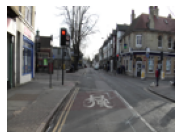

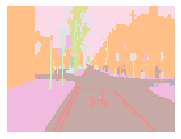

In [13]:
#test
test = (path/'images').ls()[0]
# test.stem, test.suffix
img = open_image(test)
mask = open_mask(get_mask(test))
img.show()
mask.show()

In [14]:
split = SegmentationItemList.from_folder(path/'images').split_by_rand_pct()

In [15]:
src = split.label_from_func(get_mask, classes = codes)
src

LabelLists;

Train: LabelList (80 items)
x: SegmentationItemList
Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128)
y: SegmentationLabelList
ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128)
Path: /root/.fastai/data/camvid_tiny/images;

Valid: LabelList (20 items)
x: SegmentationItemList
Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128)
y: SegmentationLabelList
ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128)
Path: /root/.fastai/data/camvid_tiny/images;

Test: None

In [16]:
data = src.transform(get_transforms(), tfm_y = True).databunch(bs = 8).normalize(imagenet_stats)

In [17]:
#test
test = (path/'images').ls()[0]
img = open_image(test)
img.data, img.shape
mask = open_mask(get_mask(test))
mask.data, mask.shape, codes[4], codes[26], codes[17]

(tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]),
 torch.Size([1, 96, 128]),
 'Building',
 'Tree',
 'Road')

In [18]:
name2id = {v: k for k, v in enumerate(codes)}

def acc_camvid(input, target):
  target = target.squeeze(1) # 8*1*96*128 --> 8*96*128
  mask = target != name2id['Void']
  pred = input.argmax(1) # 8*32*96*128 --> 8*96*128
  return (pred[mask] == target[mask]).float().mean()

In [19]:
learn = unet_learner(data, models.resnet34, metrics = acc_camvid)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [20]:
learn.__dict__

{'add_time': True,
 'bn_wd': True,
 'callback_fns': [functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)],
 'callbacks': [],
 'data': ImageDataBunch;
 
 Train: LabelList (80 items)
 x: SegmentationItemList
 Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128)
 y: SegmentationLabelList
 ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128)
 Path: /root/.fastai/data/camvid_tiny/images;
 
 Valid: LabelList (20 items)
 x: SegmentationItemList
 Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128)
 y: SegmentationLabelList
 ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128)
 Path: /root/.fastai/data/camvid_tiny/images;
 
 Test: None,
 'layer_groups': [Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), pad

In [21]:
#test
xb, yb = data.one_batch()
xb, yb = xb.cuda(), yb.cuda()
xb.shape, yb.shape

(torch.Size([8, 3, 96, 128]), torch.Size([8, 1, 96, 128]))

In [22]:
#test
ybhat = learn.model(xb)
ybhat.shape

torch.Size([8, 32, 96, 128])

In [23]:
#test
ybhat.squeeze(1).shape, yb.squeeze(1).shape
test = ybhat.argmax(1)
test.shape

torch.Size([8, 96, 128])

In [24]:
#test
x = ybhat.argmax(1)
# x.shape, x
mask = (yb != name2id['Void']).squeeze(1)
target = yb.squeeze(1)
# mask
# x.shape, mask.shape, yb.shape
nx = (x[mask] == target[mask])
nx.float().mean()

tensor(0.0159, device='cuda:0')

In [25]:
#test
# learn.loss_func
# from fastai.layers import CrossEntropyFlat
# loss_func = CrossEntropyFlat()
ybhat.shape
test = ybhat.transpose(1, -1).contiguous()


In [26]:
#test
test.shape, test.view(-1, 32).shape

(torch.Size([8, 128, 96, 32]), torch.Size([98304, 32]))

In [27]:
#test
acc_camvid(ybhat, yb)

tensor(0.0159, device='cuda:0')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


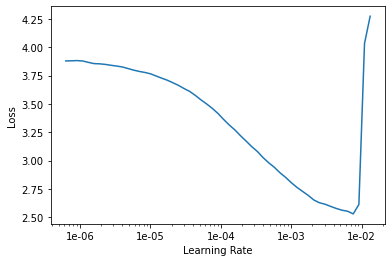

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(3, max_lr = slice(1e-03), wd = 1e-04, moms = (0.9, 0.8))

epoch,train_loss,valid_loss,acc_camvid,time
0,2.883507,2.375251,0.345663,00:01
1,2.375725,1.797377,0.475885,00:01
2,2.021129,1.550750,0.609496,00:01


In [30]:
def conv(ni, nf, stride = 2, kernel_size = (3, 3)):
  return nn.Conv2d(ni, nf, kernel_size=kernel_size, stride = stride, padding = 1)

In [31]:
def get_conv(ni, nf, stride = 2, kernel_size = (3, 3)):
  return nn.Sequential(conv(ni, nf, stride, kernel_size), nn.ReLU(), nn.BatchNorm2d(nf))

In [32]:
class ResBlock(nn.Module):
  def __init__(self, nf):
    super().__init__()
    self.layer_1 = get_conv(nf, nf, stride = (1, 1))
    self.layer_2 = get_conv(nf, nf, stride = (1, 1))
  
  def forward(self, x):
    return x + self.layer_2(self.layer_1(x))

In [33]:
class Hook():
  def __init__(self, layer):
    self.layer = layer
    self.stored = None
    self.hook = self.layer.register_forward_hook(self.hook_fn)
  
  def hook_fn(self, module, inp, out):
    self.stored = out

In [34]:
#test
xb.shape
im_size = [96, 128]
# im_size
print(*im_size)

96 128


In [35]:
#test
from fastai.vision.learner import cnn_config, has_pool_type, is_pool_type
arch = models.resnet34
model = models.resnet34(pretrained= True)
# body = create_body(model, pretrained=True)
# body
# cnn_config(arch)['cut']
cut = None
ifnone(cut, cnn_config(arch)['cut'])
# a = [1, 2, 3, 4, 5]
# a[:-2]
layers = list(model.children())
ll = list(enumerate(model.children()))
# next(i for i,o in reversed(ll) if has_pool_type(o))
cut = None
for i, o in reversed(ll):
  if has_pool_type(o):
    cut = i
    break
# cut
model = nn.Sequential(*(list(models.resnet34(pretrained= True).children())[:8]))
# model

In [36]:
#test
hooks = [Hook(i) for i in model]
print(len(hooks))

8


In [37]:
dbs = 4
img_size = [96, 128]
number_of_input_channels = None
for i in model.parameters():
  number_of_input_channels = i.shape[1]
  break
# number_of_input_channels
dummy_batch = torch.randn((dbs, number_of_input_channels, *img_size))
dummy_batch.shape

torch.Size([4, 3, 96, 128])

In [38]:
#test
dummy_ops = model(dummy_batch)
dummy_ops.shape

torch.Size([4, 512, 3, 4])

In [39]:
#test
sizes = []
for i in hooks:
  print(i.stored.shape)
  sizes.append(i.stored.shape)

torch.Size([4, 64, 48, 64])
torch.Size([4, 64, 48, 64])
torch.Size([4, 64, 48, 64])
torch.Size([4, 64, 24, 32])
torch.Size([4, 64, 24, 32])
torch.Size([4, 128, 12, 16])
torch.Size([4, 256, 6, 8])
torch.Size([4, 512, 3, 4])


In [40]:
#test
down_idxs = []
pre_shape = None
for i, res in enumerate(hooks):
  if pre_shape and pre_shape != res.stored.shape:
    down_idxs.append(i - 1)
  pre_shape = res.stored.shape
down_idxs

[2, 4, 5, 6]

In [41]:
#test
from fastai.vision.models.unet import _get_sfs_idxs
_get_sfs_idxs(sizes)

[2, 4, 5, 6]

In [42]:
dummy_ops.shape

torch.Size([4, 512, 3, 4])

In [43]:
#test
ni = sizes[-1][1]
middle_conv = nn.Sequential(get_conv(ni, ni*2, stride = 1), get_conv(ni*2, ni, stride = 1))
dummy_ops = middle_conv(dummy_ops)

In [44]:
#test
dummy_ops.shape

torch.Size([4, 512, 3, 4])

In [45]:
#test
new_hooks = [Hook(model[i]) for i in down_idxs]
len(new_hooks)

4

In [46]:
#test
sizes, down_idxs

([torch.Size([4, 64, 48, 64]),
  torch.Size([4, 64, 48, 64]),
  torch.Size([4, 64, 48, 64]),
  torch.Size([4, 64, 24, 32]),
  torch.Size([4, 64, 24, 32]),
  torch.Size([4, 128, 12, 16]),
  torch.Size([4, 256, 6, 8]),
  torch.Size([4, 512, 3, 4])],
 [2, 4, 5, 6])

In [47]:
#test
x = dummy_ops
x.shape
x_in_c = x.shape[1]
u_in_c = sizes[6][1]
# x_in_c, u_in_c
hop = hooks[6].stored
hop.shape

torch.Size([4, 256, 6, 8])

In [48]:
u_in_c, x_in_c = x_in_c, u_in_c

In [49]:
#test
shuff = PixelShuffle_ICNR(u_in_c, u_in_c//2, scale=2)
test_op = shuff(dummy_ops)

In [50]:
#test
test_op.shape, hop.shape
new_op = torch.cat((test_op, hop), dim = 1)
new_op.shape

torch.Size([4, 512, 6, 8])

In [51]:
#test
bn_hop = nn.BatchNorm2d(hop.shape[1])
new_op = torch.cat((test_op, bn_hop(hop)), dim = 1)
new_op.shape

torch.Size([4, 512, 6, 8])

In [52]:
#test
c1, c2 = get_conv(new_op.shape[1], hop.shape[1], stride = 1), ResBlock(hop.shape[1])
fop = c2(c1(new_op))
fop.shape

torch.Size([4, 256, 6, 8])

In [53]:
def get_input_channels(model):
  for i in model.parameters():
    return i.shape[1]

In [54]:
class UnetBlock(nn.Module):
  def __init__(self, up_in_c, x_in_c, hook_x):
    super().__init__()
    #up_in_c: number of channels input
    #x_in_c: number of channels in hooked output of downsampling path
    #hook_x: hooked_output of downsampling path
  
    #TODO: 1. Create a upsampling layer, where the input gets scaled to half the channel size and the double the image size
    #2. Create a conv layer
    #3. Create a res block
    
    self.shuff = PixelShuffle_ICNR(up_in_c, up_in_c//2, scale = 2)
    ni = (x_in_c + up_in_c//2)
    nf = ni//2
    
    # self.conv = get_conv(ni, nf, stride = 1)
    # self.res = ResBlock(nf)
    
    self.bn = nn.BatchNorm2d(x_in_c)
    self.hook_x = hook_x
    self.layer = nn.Sequential(get_conv(ni, nf, stride = 1), ResBlock(nf))
  
  def forward(self, x_b):
    #1. up scale the x_b by using self.shuff
    #2. check the new x_b_up shape and self.hook_x.shape matches[-1, -2], if not interpolate to that level
    #3. concat x_b with self.hook_x
    #4. return the op of self.layer(merged_inputs)
    #1
    x_b_up = self.shuff(x_b)
    hook_stored = self.bn(self.hook_x.stored)
    if x_b_up.device != hook_stored.device:
      self.hook_x = self.hook_x.cuda()
    #2
    if x_b_up.shape[-1] != hook_stored.shape[-1] or x_b_up.shape[-2] != hook_stored.shape[-2]:
      #interpolate
      x_b_up = F.interpolate(x_b_up, size = hook_stored.shape[-2:], mode = 'nearest')
    
    #3
    concated_input = torch.cat((x_b_up, hook_stored), dim = 1)
    
    #4
    return self.layer(concated_input)

In [55]:
class MergeActs(nn.Module):
  def __init__(self, hook):
    super().__init__()
    self.hook = hook
    self.bn = nn.BatchNorm2d(hook.stored.shape[1])
  
  def forward(self, x):
    y = self.hook.stored
    return torch.cat((x, y), dim = 1)

In [56]:
class UnetLearner(nn.Module):
  def __init__(self, model, image_size, num_of_classes):
    super().__init__()

    model = nn.Sequential(*[i for i in model(pretrained = True).children()][:8])

    #1. model - nn.Squential model.. where we can loop through multiple layers
    init_layer = nn.Sequential(get_conv(3, 3, stride = 1), ResBlock(3))
    self.init_layer_hook = Hook(init_layer)
    
    # self.model = model
    self.im_size = image_size if type(image_size) is list else listify(image_size)
    self.hooks = [Hook(i) for i in model]
    
    #2. create a dummy batch with a batch size > 1 -- 4 in our case
    dummy_batch = torch.randn((4, get_input_channels(model), *self.im_size))
    dummy_res = init_layer(dummy_batch)
    #3. Store all the outputs of each layer
    dummy_res = model(dummy_batch)
    
    #4.identify all the layers where the output is down_sampled
    self.down_idxs = []
    for i in range(len(self.hooks)):
      if i > 0 and self.hooks[i].stored.shape != self.hooks[i-1].stored.shape:
        self.down_idxs.append(i-1)

    #5. Create a middle conv and 
    ni = dummy_res.shape[1] 
    self.middle_conv = nn.Sequential(nn.ReLU(), nn.BatchNorm2d(ni), get_conv(ni, ni*2, stride = 1), ResBlock(ni*2) ,get_conv(ni*2, ni, stride = 1), nn.BatchNorm2d(ni))
    dummy_res = self.middle_conv(dummy_res)
    
    #for a resnet... the shape should be 4*512*x*y
    #6. Start upsampling the given output
    self.layers = [init_layer, *(i for i in model), self.middle_conv]
    
    for down_idx in reversed(self.down_idxs):
      stored_hook = self.hooks[down_idx]
      up_in_c = dummy_res.shape[1]
      x_in_c = stored_hook.stored.shape[1]
      unet_block = UnetBlock(up_in_c = up_in_c, x_in_c = x_in_c, hook_x = stored_hook)
      dummy_res = unet_block(dummy_res)
      self.layers.append(unet_block)

    #7. Basically... use of our model is over now...
    # for a resent arch: the current dummy_res shape is torch.Size([4, 48, 48, 64]) - for a 96*128 image with 32 channels
    # TODO: make the torch.Size([4, 48, 48, 64]) sized op to 4*32*96*128

    ni = dummy_res.shape[1]
    dummy_res = PixelShuffle_ICNR(ni, ni//2)(dummy_res)
    self.layers.append(PixelShuffle_ICNR(ni, ni//2))

    if dummy_res.shape[-2:] != dummy_batch.shape[-2:]:
      dummy_res = F.interpolate(dummy_res, size = dummy_batch[:-2])
      self.layers.append(F.interpolate(dummy_res, size = dummy_batch[:-2]))

    # self.first_part = nn.Sequential(*self.layers)
    #create a merge layer and get the output

    self.merge = MergeActs(self.init_layer_hook)
    dummy_res = self.merge(dummy_res)
    #create a final layer which takes this merged op and convert it to our desired shape
    ni = dummy_res.shape[1]
    nf = num_of_classes
    c1, res1 = get_conv(ni, nf, stride= 1), ResBlock(nf)
    self.last_layers = [c1, res1, nn.BatchNorm2d(nf), nn.ReLU()]
    dummy_res = nn.Sequential(*self.last_layers)(dummy_res)
    self.arch = nn.Sequential(*self.layers, self.merge, *self.last_layers)
    dummy_res = self.arch(dummy_batch)
    print(dummy_res.shape)
    
  def forward(self, xb):
    return self.arch(xb)


In [57]:
# test
test = UnetLearner(models.resnet34, [96, 128], len(data.classes)).cuda()
for xb, yb in data.train_dl:
  pass

torch.Size([4, 32, 96, 128])


In [58]:
xb.shape, yb.shape, xb.device

(torch.Size([8, 3, 96, 128]),
 torch.Size([8, 1, 96, 128]),
 device(type='cuda', index=0))

In [59]:
res = test(xb)
res.shape

torch.Size([8, 32, 96, 128])

In [60]:
#test
b = [1, 2, 3, 4]
a = recurse(lambda x: x**2, b)
a, b

([1, 4, 9, 16], [1, 2, 3, 4])

In [61]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [62]:
#test
m = nn.Sequential(
    nn.Conv2d(1, 32, 5, 1, 1),
    nn.Flatten())
m

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (1): Flatten()
)

In [63]:
#test
x = torch.randn((1, 1, 10, 10))
x.shape
res = m(x)
res.shape

torch.Size([1, 2048])

In [64]:
#test
l = nn.Conv2d(1, 32, 5, 1, 1)
res = l(x)
res.shape

torch.Size([1, 32, 8, 8])

In [65]:
#test
from fastai.torch_core import *
layers = [i for i in models.resnet34().children()]
layers = layers[:8]
test_m = nn.Sequential(*layers)
flat_test_m = flatten_model(test_m)
# flat_test_m, layers

In [66]:
from fastai.callback import *
c = Callback

In [67]:
losses = []
v_losses = []
loss_func = learn.loss_func
unet_learner = UnetLearner(models.resnet34, [96, 128], 32).cuda()
print("{} -- {} -- {}".format('epoch', 'train_loss', 'valid_loss'))
def update(lr, wd, moms, epocs = 10):
  optim = torch.optim.Adam(unet_learner.parameters(), lr = lr, weight_decay=wd, betas = (0.9, 0.9))
  e = 0
  while e <= epocs:
    lo = torch.Tensor()
    vlo = torch.Tensor()
    for xb, yb in data.train_dl:
      yhat = unet_learner(xb)
      loss = loss_func(yhat, yb)
      loss.backward()
      optim.step()
      optim.zero_grad()
      lo = torch.cat((lo, torch.Tensor([loss.item()])), dim = 0)
    
    with torch.no_grad():
      for xb, yb in data.valid_dl:
        yhat = unet_learner(xb)
        loss = loss_func(yhat, yb)
        optim.zero_grad()
        vlo = torch.cat((vlo, torch.Tensor([loss.item()])), dim = 0)
    
    e += 1
    # print(lo, vlo)
    losses.append(lo.mean())
    v_losses.append(vlo.mean())
    print("{} -- {} -- {}".format(e, lo.mean(), vlo.mean()))

update(lr = 1e-02, wd = 1e-04, moms = 0)

torch.Size([4, 32, 96, 128])
epoch -- train_loss -- valid_loss
1 -- 3.0014917850494385 -- 2.5850980281829834
2 -- 2.453192710876465 -- 2.3351142406463623
3 -- 2.2250514030456543 -- 2.1836133003234863
4 -- 2.1043593883514404 -- 2.0635015964508057
5 -- 1.9733966588974 -- 1.9564377069473267
6 -- 1.8266916275024414 -- 1.8155287504196167
7 -- 1.7040449380874634 -- 1.7240285873413086
8 -- 1.602975845336914 -- 1.6357269287109375
9 -- 1.4960525035858154 -- 1.584606647491455
10 -- 1.4211663007736206 -- 1.483042597770691
11 -- 1.3541733026504517 -- 1.3685535192489624


([<matplotlib.lines.Line2D at 0x7fe2016ba978>],
 [<matplotlib.lines.Line2D at 0x7fe2016baa90>])

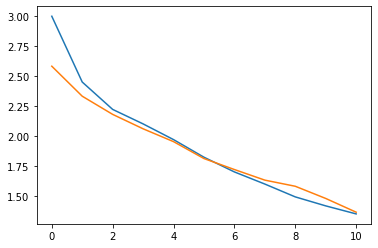

In [68]:
plt.plot(losses), plt.plot(v_losses)

In [69]:
#test
# test = torch.cat((data.train_ds[0][0], data.train_ds[0][1]). dim = 0)
test = data.train_ds[0][0].data[None], data.train_ds[1][0].data[None]
test = torch.cat(test, dim = 0)
test = test.cuda()

y = data.train_ds[0][1].data[None], data.train_ds[1][1].data[None]
y = torch.cat(y, dim = 0)
y = y.cuda()
y.shape, test.shape

(torch.Size([2, 1, 96, 128]), torch.Size([2, 3, 96, 128]))

In [70]:
#test
tres = unet_learner(test)
tres.shape

torch.Size([2, 32, 96, 128])

In [71]:
#test
nres = tres.argmax(dim = 1)
nres.shape

torch.Size([2, 96, 128])

In [72]:
acc_camvid(tres, y)

tensor(0.5813, device='cuda:0')

In [82]:
#test
test = torch.randn(3, 4, 5)
# test = torch.randint(0, 2, (4,5)).float()
test.shape, test

(torch.Size([3, 4, 5]), tensor([[[-0.7568,  0.0490,  0.3440, -0.1950,  1.7393],
          [ 0.3348, -0.1025,  0.7781,  0.1661,  0.0908],
          [-0.5839,  2.6850,  2.4140, -0.0257, -0.1869],
          [-0.6153,  0.1048, -0.2995, -0.1649, -0.0261]],
 
         [[-0.7566, -0.0718,  1.7465, -0.7903,  0.0921],
          [-0.1547,  0.2777,  2.4969,  0.2602,  0.2552],
          [-0.5337, -0.8901,  0.0449, -1.0099,  0.3616],
          [ 0.4111, -0.9005,  0.6895,  2.0578, -0.1571]],
 
         [[ 1.2707, -0.9753, -0.8372, -0.2786, -1.7857],
          [ 0.3436,  1.2657, -0.1504, -1.4172,  1.9779],
          [ 0.1258, -0.9390,  0.3486,  0.2361, -1.0007],
          [ 0.8640, -1.0623,  1.7746,  0.5046, -1.1707]]]))

In [85]:
#test
l = nn.Flatten(start_dim = 2)
l(test).shape

torch.Size([3, 4, 5])

In [86]:
doc(CrossEntropyFlat)

In [87]:
#test
loss_fn = CrossEntropyFlat()
for x, y in data.train_dl:
  break
yhat = unet_learner(x)

In [102]:
loss_fn = learn.loss_func
print('inda')
loss = loss_fn(yhat, y)
loss

inda


tensor(1.1010, device='cuda:0', grad_fn=<NllLossBackward>)

In [100]:
#test
yhat.shape, y.shape
loss_fn = CrossEntropyFlat(axis= 1)
# loss_fn.__dict__
yhat.shape, y.shape
# st()
loss_fn(yhat, y), loss

tensor(1.1010, device='cuda:0', grad_fn=<NllLossBackward>)